XGBOOST

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import holidays
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from datetime import timedelta


In [2]:
df = pd.read_csv("Births2015.csv")
df = df.drop(columns = ['Unnamed: 0', 'wday'], axis = 1)
df['date'] = pd.to_datetime(df['date'])
df.describe()
df = df.set_index('date')

Test/Train Split

Time Series Cross Validation

In [3]:
tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=1)
df = df.sort_index()

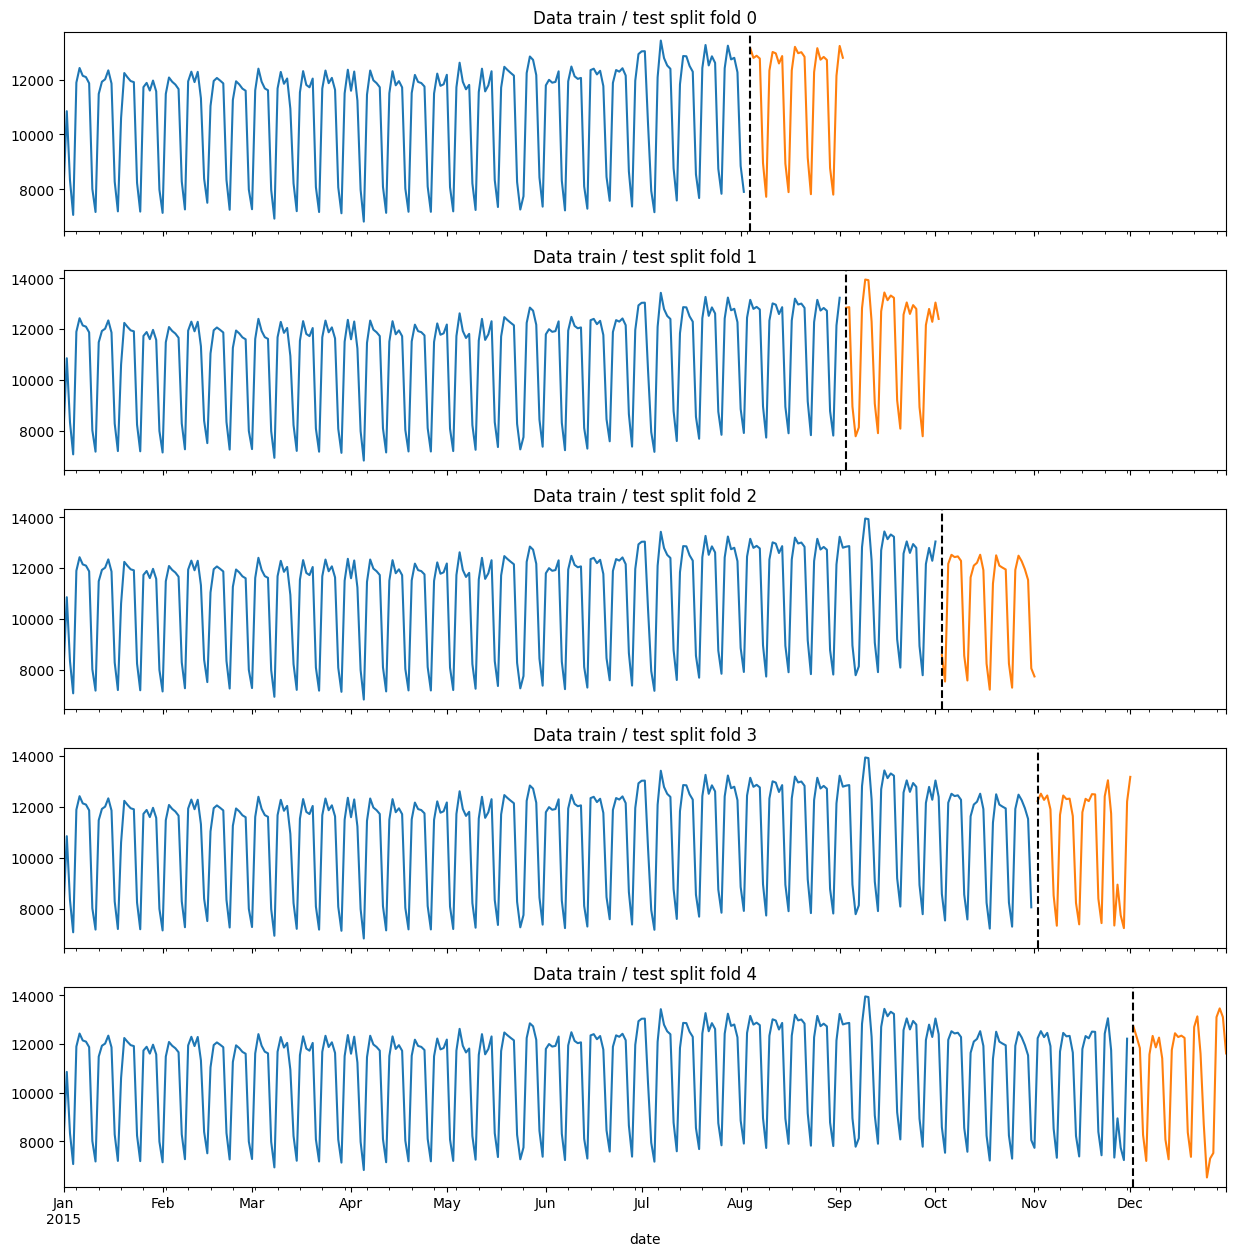

In [4]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex = True)
fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['births'].plot(ax=axs[fold], 
                        label="Training Set",
                        title=f'Data train / test split fold {fold}')
    test['births'].plot(ax=axs[fold], 
                        label="Test Set")
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

In [5]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES= [ 'day_of_month', 'day_of_week',
       'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'month_sin', 'month_cos', 'day_of_quarter',
       'is_month_end', 'lag7_births', 'lag14_births', 'lag4_births',
       'lag6_births', 'rolling_std', 'rolling_mean', 'rolling_max',
       'rolling_min', 'is_us_holiday']
    TARGET = 'births'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

NameError: name 'create_features' is not defined

In [ ]:
scores

Feature Creation

In [6]:
# Function to check if a date is a US holiday
def is_us_holiday(date):
    us_holidays = holidays.US(years=date.year)
    return date in us_holidays


def create_features(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    
    df['day_of_week_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    df['day_of_month_sin'] = np.sin(2 * np.pi * df.index.day / 30)
    df['day_of_month_cos'] = np.cos(2 * np.pi * df.index.day / 30)
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 11)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 11)
    df['day_of_quarter'] = (df.index.dayofyear - 1) % 91 + 1
    #df['week_of_month'] = df.index.day // 7 + 1
    #df['quarter_of_year'] = df.index.quarter
    #df['week_of_year'] = df.index.isocalendar().week.astype('int32')
    #df["is_wknd"] = df.index.weekday // 4
    #df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    #df['season'] = df['month'] % 12 // 3 + 1
    df['lag7_births'] = df['births'].shift(periods=7)
    df['lag14_births'] = df['births'].shift(periods=14)
    df['lag4_births'] = df['births'].shift(periods=4)
    df['lag6_births'] = df['births'].shift(periods=6)
    #df['births_diff7'] = df['births'].shift(7) - df['births'].shift(14)
    window_size = 7
    df['rolling_std'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").std()

    # Calculate the rolling mean, max, and min for the relevant columns
    #df['rolling_mean7'] = df['lag7_births'].rolling(window=window_size, min_periods=1, closed= "left").mean()
    #df['rolling_max7'] = df['lag7_births'].rolling(window=window_size, min_periods=1, closed= "left").max()
    #df['rolling_min7'] = df['lag7_births'].rolling(window=window_size, min_periods=1, closed= "left").min()
    df['rolling_mean'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").mean()
    df['rolling_max'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").max()
    df['rolling_min'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").min()
    # Add 'is_us_holiday' column to DataFrame
    df['is_us_holiday'] = df.index.map(is_us_holiday).astype(int)
    return df


In [7]:
df = create_features(df)

In [8]:
train = df[:335]
test = df[335:]

visualize

Text(0.5, 1.0, 'births by day')

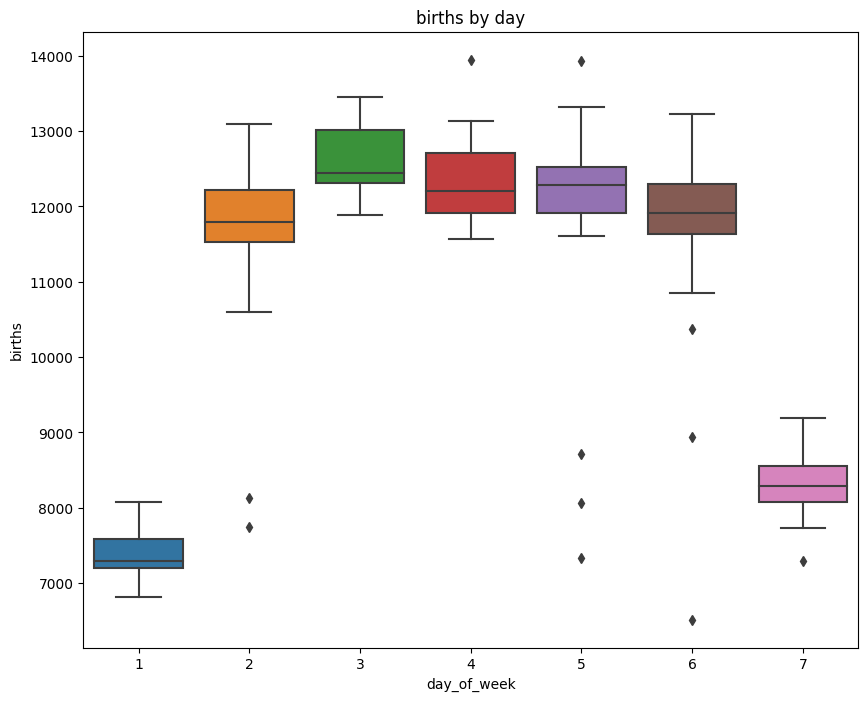

In [9]:
fig, ax= plt.subplots(figsize=(10,8))
sns.boxplot(data = df, x='day_of_week', y='births')
ax.set_title("births by day")

create model

In [10]:
df.columns

Index(['births', 'year', 'month', 'day_of_year', 'day_of_month', 'day_of_week',
       'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'month_sin', 'month_cos', 'day_of_quarter',
       'is_month_end', 'lag7_births', 'lag14_births', 'lag4_births',
       'lag6_births', 'rolling_std', 'rolling_mean', 'rolling_max',
       'rolling_min', 'is_us_holiday'],
      dtype='object')

In [11]:
FEATURES= ['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'month_sin', 'month_cos', 'day_of_quarter',
       'is_month_end', 'lag7_births', 'lag14_births', 'lag4_births',
       'lag6_births', 'rolling_std', 'rolling_mean', 'rolling_max',
       'rolling_min', 'is_us_holiday']
TARGET = 'births'

In [12]:
train = train.dropna()
test= test.dropna()

In [13]:
X_train = train[FEATURES]
y_train = train[TARGET]


In [14]:
X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
len(test)

30

<Axes: >

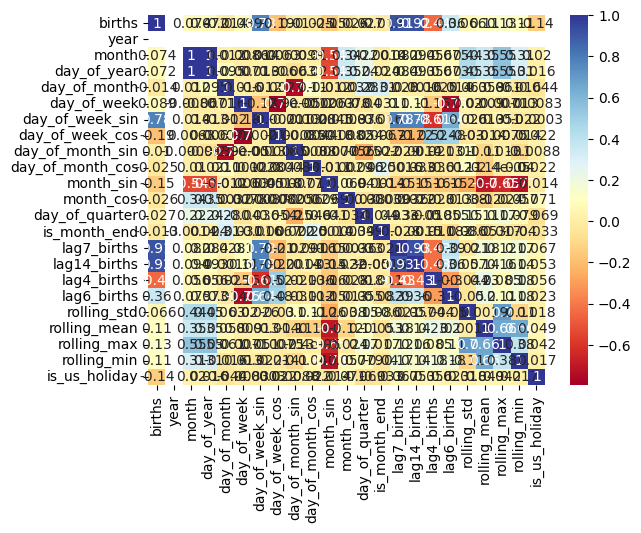

In [16]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlBu')

RANDOM SEARCH FOR HYPERPARAMETERS

In [33]:
# Assuming you have your feature matrix X and target vector y
xgb_reg = xgb.XGBRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 250],
    'base_score': [0.3, 0.5, 0.7],
    'learning_rate' : [0.0001, 0.001, 0.01],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.2, 0.4],
    'early_stopping_rounds': [25]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_grid, n_iter=20,
                                   scoring='neg_mean_squared_error', cv=5, verbose=False, random_state=42)

# Perform the random search on the data
random_search.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  )

# Print the best hyperparameters and corresponding mean cross-validated score
print("Best Hyperparameters: ", random_search.best_params_)
print("Best MSE Score: ", -random_search.best_score_)
best_params = random_search.best_params_

[0]	validation_0-rmse:11125.94028	validation_1-rmse:10986.47118
[1]	validation_0-rmse:11124.83290	validation_1-rmse:10985.36150
[2]	validation_0-rmse:11123.72039	validation_1-rmse:10984.24656
[3]	validation_0-rmse:11122.61361	validation_1-rmse:10983.18020
[4]	validation_0-rmse:11121.50876	validation_1-rmse:10982.11634
[5]	validation_0-rmse:11120.40614	validation_1-rmse:10981.01159
[6]	validation_0-rmse:11119.29906	validation_1-rmse:10979.90230
[7]	validation_0-rmse:11118.19413	validation_1-rmse:10978.79511
[8]	validation_0-rmse:11117.08934	validation_1-rmse:10977.68799
[9]	validation_0-rmse:11115.98273	validation_1-rmse:10976.57924
[10]	validation_0-rmse:11114.87696	validation_1-rmse:10975.47120
[11]	validation_0-rmse:11113.76917	validation_1-rmse:10974.36119
[12]	validation_0-rmse:11112.66339	validation_1-rmse:10973.25307
[13]	validation_0-rmse:11111.56208	validation_1-rmse:10972.19287
[14]	validation_0-rmse:11110.45773	validation_1-rmse:10971.11261
[15]	validation_0-rmse:11109.35641	

[30]	validation_0-rmse:11092.79971	validation_1-rmse:10953.57352
[31]	validation_0-rmse:11091.69937	validation_1-rmse:10952.47092
[32]	validation_0-rmse:11090.59248	validation_1-rmse:10951.36177
[33]	validation_0-rmse:11089.49347	validation_1-rmse:10950.30339
[34]	validation_0-rmse:11088.38786	validation_1-rmse:10949.19568
[35]	validation_0-rmse:11087.28846	validation_1-rmse:10948.13737
[36]	validation_0-rmse:11086.18436	validation_1-rmse:10947.03093
[37]	validation_0-rmse:11085.08144	validation_1-rmse:10945.92582
[38]	validation_0-rmse:11083.97609	validation_1-rmse:10944.86152
[39]	validation_0-rmse:11082.87456	validation_1-rmse:10943.75776
[40]	validation_0-rmse:11081.76928	validation_1-rmse:10942.65015
[41]	validation_0-rmse:11080.66805	validation_1-rmse:10941.54683
[42]	validation_0-rmse:11079.57137	validation_1-rmse:10940.47382
[43]	validation_0-rmse:11078.47033	validation_1-rmse:10939.37082
[44]	validation_0-rmse:11077.36604	validation_1-rmse:10938.30732
[45]	validation_0-rmse:11

In [36]:

# Print the best hyperparameters and corresponding mean cross-validated score
print("Best Hyperparameters: ", random_search.best_params_)
print("Best MSE Score: ", -random_search.best_score_)
best_params = random_search.best_params_

Best Hyperparameters:  {'subsample': 1.0, 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'early_stopping_rounds': 25, 'colsample_bytree': 0.8, 'base_score': 0.3}
Best MSE Score:  1271098.4849184905


ImportError: You must install graphviz to plot tree

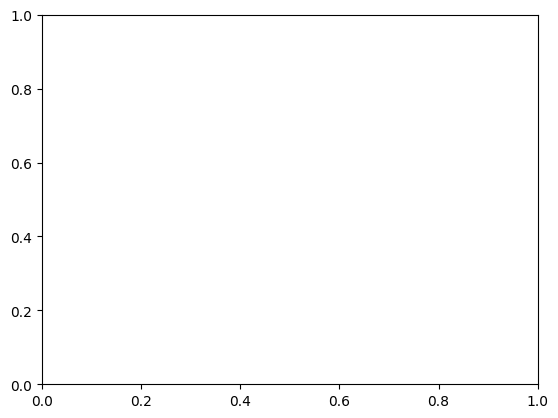

In [25]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
plot_tree(random_search.best_estimator_)
plt.show()

In [31]:
random_search.cv_results_

{'mean_fit_time': array([0.72181239, 0.67683244, 0.92840014, 0.77620354, 0.80610394,
        0.37739968, 0.41040716, 0.93550181]),
 'std_fit_time': array([0.05746165, 0.08053228, 0.09788725, 0.02747865, 0.05231572,
        0.05186683, 0.05785847, 0.07926272]),
 'mean_score_time': array([0.00459456, 0.00459952, 0.00479999, 0.00499697, 0.00499973,
        0.00840049, 0.00599966, 0.00640173]),
 'std_score_time': array([0.00049305, 0.00049043, 0.00074824, 0.00062715, 0.00109528,
        0.00557226, 0.00282888, 0.00332223]),
 'param_subsample': masked_array(data=[0.8, 0.8, 0.8, 0.8, 1.0, 0.8, 1.0, 0.8],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[250, 200, 250, 200, 200, 100, 100, 250],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[9, 9, 9, 3, 7,

In [32]:
mModel = xgb.XGBRegressor(**best_params)
mModel.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)


train_preds = (pd.DataFrame(mModel.predict(X_train), index=y_train.index))
val_preds =  (pd.DataFrame(mModel.predict(X_test), index=y_test.index))
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

 

print(f"train_MSE: {mse(train_preds, y_train)}")
print(f"train_MAE: {mae(train_preds, y_train)}")
print(f"val_MSE: {mse(val_preds, y_test)}")
print(f"val_MAE: {mae(val_preds, y_test)}")

 

import plotly.io as pio
import plotly.graph_objects as go

 

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_preds.index, y=train_preds[0],  name="train_preds", line=dict(color='blue'))
)

 

fig.add_trace(
    go.Scatter(x=val_preds.index, y=val_preds[0],  name="val_preds", line=dict(color='cyan'))
)
fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_train).index, y=pd.DataFrame(y_train)["births"],  name="train_target", line=dict(color='brown'))
)
fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_test).index, y=pd.DataFrame(y_test)["births"],  name="val_target", line=dict(color='black'))
)
fig.update_layout(height=600)
fig.show()


[0]	validation_0-rmse:11016.78422	validation_1-rmse:10877.10476
[1]	validation_0-rmse:10907.83658	validation_1-rmse:10767.96591
[2]	validation_0-rmse:10799.53404	validation_1-rmse:10659.46448
[3]	validation_0-rmse:10692.89703	validation_1-rmse:10552.65489
[4]	validation_0-rmse:10587.29730	validation_1-rmse:10446.89532
[5]	validation_0-rmse:10482.93543	validation_1-rmse:10342.38034
[6]	validation_0-rmse:10379.40599	validation_1-rmse:10238.72073
[7]	validation_0-rmse:10276.60587	validation_1-rmse:10135.80451
[8]	validation_0-rmse:10175.08323	validation_1-rmse:10034.17374
[9]	validation_0-rmse:10074.59546	validation_1-rmse:9933.57969
[10]	validation_0-rmse:9975.03971	validation_1-rmse:9833.93953
[11]	validation_0-rmse:9876.77998	validation_1-rmse:9735.59992
[12]	validation_0-rmse:9779.34504	validation_1-rmse:9638.10935
[13]	validation_0-rmse:9683.03404	validation_1-rmse:9541.75187
[14]	validation_0-rmse:9587.15911	validation_1-rmse:9445.84709
[15]	validation_0-rmse:9492.95884	validation_1

[28]	validation_0-rmse:8344.85508	validation_1-rmse:8204.06186
[29]	validation_0-rmse:8262.45958	validation_1-rmse:8121.83023
[30]	validation_0-rmse:8181.27674	validation_1-rmse:8040.58092
[31]	validation_0-rmse:8100.57240	validation_1-rmse:7960.05950
[32]	validation_0-rmse:8021.05218	validation_1-rmse:7880.73806
[33]	validation_0-rmse:7942.02907	validation_1-rmse:7801.92801
[34]	validation_0-rmse:7863.59728	validation_1-rmse:7723.71771
[35]	validation_0-rmse:7786.27210	validation_1-rmse:7646.36149
[36]	validation_0-rmse:7709.54416	validation_1-rmse:7569.86211
[37]	validation_0-rmse:7633.55212	validation_1-rmse:7493.90600
[38]	validation_0-rmse:7558.57855	validation_1-rmse:7419.20312
[39]	validation_0-rmse:7483.95099	validation_1-rmse:7344.83873
[40]	validation_0-rmse:7410.26253	validation_1-rmse:7271.14908
[41]	validation_0-rmse:7337.84312	validation_1-rmse:7198.70067
[42]	validation_0-rmse:7266.14946	validation_1-rmse:7127.31896
[43]	validation_0-rmse:7194.16833	validation_1-rmse:705

Feature Importance

In [28]:
fi = pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])

NameError: name 'reg' is not defined

In [ ]:
reg.feature_importances_, reg.feature_names_in_


In [ ]:
fi.sort_values('importance').plot(kind='barh', title= 'Feature Importance')
plt.show()
#overlapping high correlated features do not exactly tell the right values 'day_of_week_sin',

Forecast on the test set

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)

In [ ]:
ax= df[['births']].plot(figsize= (15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title("RAW DATA AND PREDICTION")
plt.show()

In [ ]:
ax= df.loc[(df.index > '12-01-2015') & (df.index <= '12-31-2015')]['births'].plot(figsize= (15,5), title= "december data")
df.loc[(df.index > '12-01-2015') & (df.index <= '12-31-2015')]['prediction'].plot( style='.')
plt.legend(['Truth Data', 'Predictions'])
plt.show()

In [ ]:
import plotly.graph_objects as go

# Assuming you have the DataFrame df with 'births' and 'prediction' columns

# Create the figure object
fig = go.Figure()

# Add the 'births' trace to the figure
fig.add_trace(go.Scatter(x=df.index, y=df['births'], mode='lines', name='Truth Data'))

# Add the 'prediction' trace to the figure
fig.add_trace(go.Scatter(x=df.index, y=df['prediction'], mode='lines', name='Predictions'))

# Update the layout of the figure
fig.update_layout(title='RAW DATA AND PREDICTION',
                  xaxis_title='Date',
                  yaxis_title='Births',
                  showlegend=True,
                  legend_title_text='Legend')

# Show the plot
fig.show()


In [ ]:
score = np.sqrt(mean_squared_error(test['births'], test['prediction']))
print(f'RMSE: {score:0.2f}')

CALCULATE ERROR

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [ ]:
test.groupby(['date'])['error'].mean().sort_values(ascending= False).head(5)